# RNN Preprocessing

In [1]:
#utils check 
import preprocessing

#import packages
import string
# import glove
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# word2vec
from gensim.models import Word2Vec

# RNN
from keras.callbacks import LambdaCallback
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Activation
from keras.models import Sequential

Using TensorFlow backend.


In [2]:
# Global variables
histPath = 'word2vec/'

## I. Data Preprocessing

In [3]:
#load dataset
data = pd.read_csv('../data/papers.csv')
dataNew = preprocessing.preprocessing(data, dropnan = True)
#check data## I. Data Preprocessing
dataNew.head()

,id,year,title,event_type,pdf_name,abstract,paper_text,aLen,tLen
0,1,1987,self-organization of associative database and ...,NaN,1-self-organization-of-associative-database-an...,an efficient method of self-organizing associa...,767 self-organization of associative database...,73,7
1,10,1987,a mean field theory of layer iv of visual cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,a single cell theory for the development of se...,683 a mean field theory of layer iv of visual...,91,17
2,100,1988,storing covariance by the associative long-ter...,NaN,100-storing-covariance-by-the-associative-long...,in modeling studies or memory based on neural...,394 storing covariance by the associative lon...,300,15
3,1000,1994,bayesian query construction for neural network...,NaN,1000-bayesian-query-construction-for-neural-ne...,"if data collection is costly, there is much to...",bayesian query construction for neural network...,94,7
4,1001,1994,"neural network ensembles, cross validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,learning of continuous valued functions using ...,"neural network ensembles, cross validation, an...",129,8


In [4]:
dataNew.shape

(7174, 9)

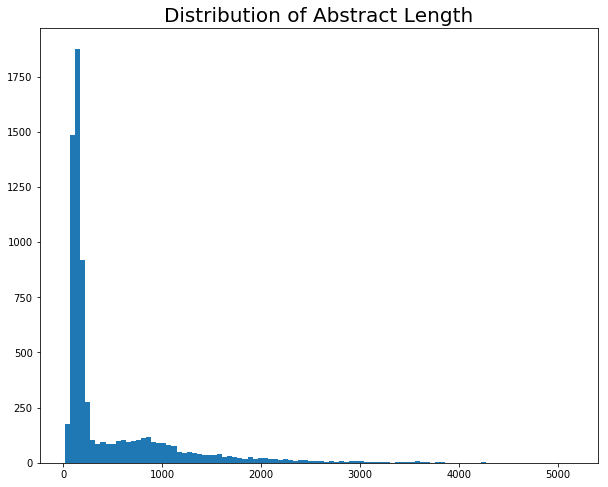

In [5]:
#visualize distribution 
fig, ax = plt.subplots(figsize = (10, 8))
ax.hist(dataNew.aLen, bins = 100)
ax.set_title('Distribution of Abstract Length', fontsize = 20)
plt.show()

In [6]:
#for now we use articles with a length less than 250
data250 = dataNew[dataNew.aLen <= 250]
data250.shape

(4638, 9)

In [7]:
print('Maximum title length: ', data250.tLen.max())

Maximum title length:  20


In [8]:
#tokenize data
prep = preprocessing.processText(data250[['title', 'abstract']].values.T)
#get dictionaries of word and tags
prep.getDictionary()
#update sequence length
prep.updateMaxLen()
print('Number of unique words: ', prep.nUnique)
print('Maxmimum sequence length: ', prep.maxLen)

Number of unique words:  32468
Maxmimum sequence length:  250


In [9]:
#get tokenized vector of text
txtTokenized = prep.tokenize()
titles = txtTokenized[0]
abstracts = txtTokenized[1]
print('Example of tokenized title:\n {0} => {1}'.format(titles[0], [prep.idx2word[i] for i in titles[0]]))
print('Example of tokenized abstract:\n {0} => {1}'.format(abstracts[0],[prep.idx2word[i] for i in abstracts[0]]))

Example of tokenized title:
 [3, 4, 5, 6, 7, 8, 9] => ['self-organization', 'of', 'associative', 'database', 'and', 'its', 'applications']
Example of tokenized abstract:
 [42, 466, 64, 4, 580, 5, 5497, 431, 5498, 5499, 51, 9, 19, 321, 5500, 5501, 58, 5498, 5497, 176, 5502, 3251, 503, 51, 309, 5503, 75, 58, 619, 5504, 1743, 4, 5505, 42, 61, 4, 3, 431, 5506, 368, 42, 1019, 4, 5507, 1727, 5508, 10, 289, 4072, 4, 21, 5509, 75, 58, 5510, 5504, 5511, 42, 5512, 19, 187, 1181, 92, 7, 122, 19, 42, 319, 320, 321, 159, 1391, 5513] => ['an', 'efficient', 'method', 'of', 'self-organizing', 'associative', 'databases', 'is', 'proposed', 'together', 'with', 'applications', 'to', 'robot', 'eyesight', 'systems.', 'the', 'proposed', 'databases', 'can', 'associate', 'any', 'input', 'with', 'some', 'output.', 'in', 'the', 'first', 'half', 'part', 'of', 'discussion,', 'an', 'algorithm', 'of', 'self-organization', 'is', 'proposed.', 'from', 'an', 'aspect', 'of', 'hardware,', 'it', 'produces', 'a', 'new', 'st

In [10]:
#split data into train, validation, and test set
trainX, testX, trainY, testY = train_test_split(abstracts, titles, test_size = 0.2 , random_state = 209)
trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size = 0.1 , random_state = 209)

print('Number of training samples: ', len(trainX))
print('Number of validation samples: ', len(valX))
print('Number of test samples: ', len(testX))

Number of training samples:  3339
Number of validation samples:  371
Number of test samples:  928


In [11]:
import pickle

with open(histPath + "trainXY.pickle", "wb") as f:
    pickle.dump((trainX, trainY), f)

with open(histPath + "valXY.pickle", "wb") as f:
    pickle.dump((valX, valY), f)

with open(histPath + "testXY.pickle", "wb") as f:
    pickle.dump((testX, testY), f)
# with open("tmp.pickle", "rb") as f:
#     a,b = pickle.load(f) 

---
## Word2vec
### Get word2vec weights for training data

In [12]:
abstracts_list_word = []
for i in range(len(abstracts)):
    abstracts_list_word.append([prep.idx2word[word] for word in abstracts[i]])

In [13]:
from gensim.models import Word2Vec
sentences = [["cat", "say", "meow"], ["dog", "say", "woof"]]
model = Word2Vec(sentences, min_count=1)
say_vector = model['say']

In [14]:
model.most_similar("dog")

[('meow', 0.16170072555541992),
 ('cat', -0.009135335683822632),
 ('woof', -0.0508573055267334),
 ('say', -0.10918344557285309)]

In [22]:
print('\nTraining word2vec...')
word_model = Word2Vec(abstracts_list_word, size=100, min_count=500, window=5, iter=100)
pretrained_weights = word_model.wv.syn0
# vocab_size, emdedding_size = pretrained_weights.shape
# print('Result embedding shape:', pretrained_weights.shape)


Training word2vec...


In [16]:
print('\nTraining word2vec...')
word_model2 = Word2Vec(abstracts_list_word, size=100, min_count=500, window=5, iter=100)
pretrained_weights2 = word_model2.wv.syn0
# vocab_size, emdedding_size = pretrained_weights.shape
# print('Result embedding shape:', pretrained_weights.shape)


Training word2vec...


In [17]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
#     plt.show()

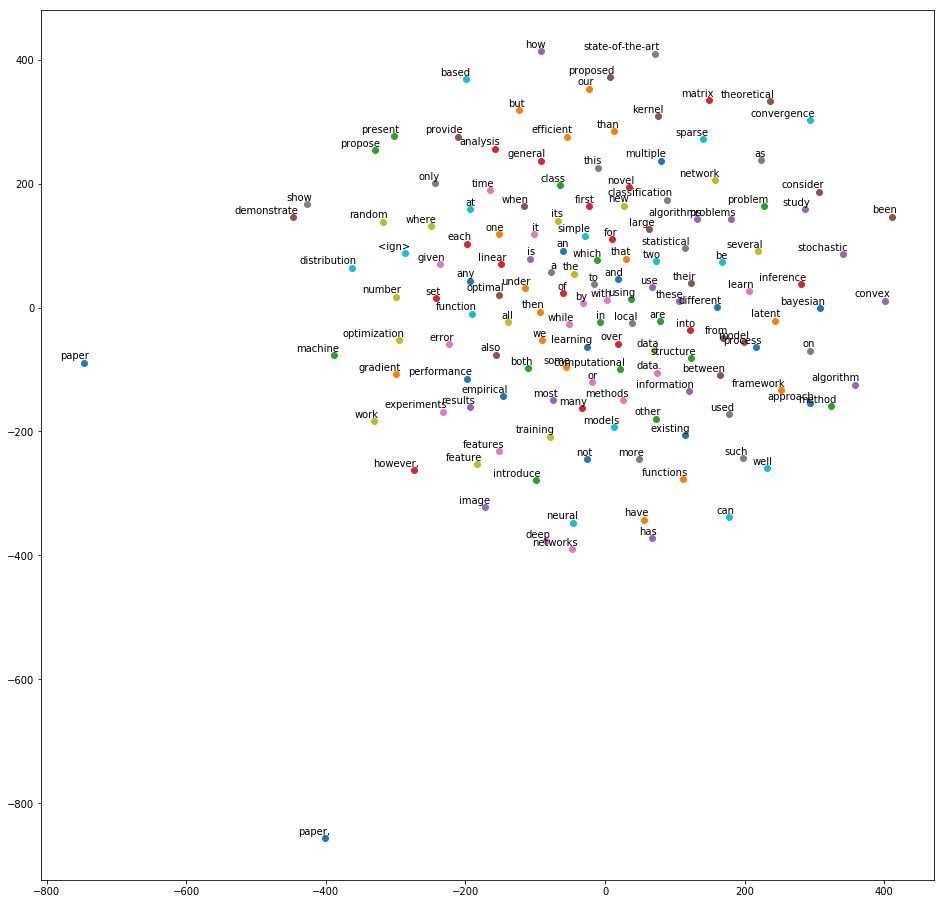

AttributeError: module 'matplotlib.pyplot' has no attribute 'save_fig'

In [19]:
# model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=500, workers=4)

from sklearn.manifold import TSNE

tsne_plot(word_model2)
plt.save_fig("tsne-word2vec.png", bbox_inches= "tight")

In [21]:
word_model.train(abstracts_list_word, total_examples=len(abstracts_list_word), epochs=10, compute_loss = True)

NameError: name 'word_model' is not defined

In [20]:
pretrained_weights = word_model.wv.syn0
vocab_size, emdedding_size = pretrained_weights.shape
print('Result embedding shape:', pretrained_weights.shape)

Result embedding shape: (31520, 100)


In [21]:
embeddMatrix = np.zeros(shape = (len(prep.word2idx.keys()), 100))

In [22]:
np.save(histPath+'embeddMatrix_word2vec_0512.npy', embeddMatrix)

In [53]:
# Add unseen vocab to the embedMatrix
all_unique_words = list(prep.word2idx.keys())
embeddMatrix = np.zeros(shape = (len(all_unique_words), 100)) # initiate with zero

for i, word in enumerate(all_unique_words):
    try:
        embeddMatrix[i] = word_model.wv.word_vec(word)
    except KeyError: # unseen vocab stay with 0
        continue

In [34]:
prev_embed = np.load(histPath+'embeddMatrix_word2vec_0510.npy')
prev_embed.shape

(32471, 100)

In [36]:
(32471 - 31520)/32471

0.029287672076622216

In [35]:
np.where(prev_embed == np.zeros(shape = (len(all_unique_words), 100)))

NameError: name 'all_unique_words' is not defined

In [55]:
embeddMatrix.shape

(32471, 100)

In [29]:
word = "barn"
print(word_model.wv.most_similar(word))
word_model2.wv.most_similar(word)

[('owl', 0.722604513168335), ('owls', 0.5831006765365601), ('owl.', 0.5801175832748413), ('map-like', 0.5587378144264221), ('heading', 0.5193907022476196), ('microstimulation', 0.5187129974365234), ("owl's", 0.5092039108276367), ('young', 0.4995405077934265), ('experiment.', 0.48575904965400696), ('formerly', 0.48051244020462036)]


[('owl', 0.7520514726638794),
 ('owls', 0.5810534954071045),
 ("owl's", 0.5604633092880249),
 ('owl.', 0.5303975343704224),
 ('heading', 0.5188189744949341),
 ('young', 0.51179438829422),
 ('map-like', 0.4981347322463989),
 ('colliculus,', 0.4962541162967682),
 ('bulb', 0.491260290145874),
 ('colliculus', 0.48262056708335876)]

In [30]:
word = "the"
print(word_model.wv.most_similar(word))
word_model2.wv.most_similar(word)

[('a', 0.5385491847991943), ('its', 0.5181876420974731), ('this', 0.496133953332901), ('of', 0.4838804602622986), ('our', 0.47673287987709045), ('an', 0.46297353506088257), ('whose', 0.3972443640232086), ('his', 0.37001141905784607), ('any', 0.36873072385787964), ('their', 0.36418911814689636)]


[('a', 0.7064133882522583),
 ('of', 0.6472048759460449),
 ('this', 0.5926291942596436),
 ('an', 0.5803326368331909),
 ('its', 0.5721151232719421),
 ('our', 0.5254557132720947),
 ('and', 0.5089436769485474),
 ('that', 0.5055457353591919),
 ('to', 0.4900032877922058),
 ('<ign>', 0.47392064332962036)]

In [25]:
print('Checking similar words:')
for word in ['model', 'machine', 'robot', 'barn']:
    most_similar = ', '.join('%s (%.2f)' % (similar, dist) for similar, dist in word_model.wv.most_similar(word)[:8])
    print('  %s -> %s' % (word, most_similar))


Checking similar words:
  model -> latent (0.57), process (0.52), approach (0.41), framework (0.39), models (0.38), distribution (0.36), image (0.33), network (0.32)
  machine -> been (0.35), problems (0.29), many (0.28), however, (0.28), learning (0.26), deep (0.24), work (0.22), most (0.21)


KeyError: "word 'robot' not in vocabulary"

### Prepare Data for LSTM

In [87]:
X_train_list_word[0]

['we',
 'propose',
 'a',
 'class',
 'of',
 'sparse',
 'coding',
 'models',
 'that',
 'utilizes',
 'a',
 'laplacian',
 'scale',
 'mixture',
 '<ign>',
 'prior',
 'to',
 'model',
 'dependencies',
 'among',
 'coefficients.',
 'each',
 'coefficient',
 'is',
 'modeled',
 'as',
 'a',
 'laplacian',
 'distribution',
 'with',
 'a',
 'variable',
 'scale',
 'parameter,',
 'with',
 'a',
 'gamma',
 'distribution',
 'prior',
 'over',
 'the',
 'scale',
 'parameter.',
 'we',
 'show',
 'that,',
 'due',
 'to',
 'the',
 'conjugacy',
 'of',
 'the',
 'gamma',
 'prior,',
 'it',
 'is',
 'possible',
 'to',
 'derive',
 'efficient',
 'inference',
 'procedures',
 'for',
 'both',
 'the',
 'coefficients',
 'and',
 'the',
 'scale',
 'parameter.',
 'when',
 'the',
 'scale',
 'parameters',
 'of',
 'a',
 'group',
 'of',
 'coefficients',
 'are',
 'combined',
 'into',
 'a',
 'single',
 'variable,',
 'it',
 'is',
 'possible',
 'to',
 'describe',
 'the',
 'dependencies',
 'that',
 'occur',
 'due',
 'to',
 'common',
 'ampli

In [86]:
X_train_list_word[0][:-1]

['we',
 'propose',
 'a',
 'class',
 'of',
 'sparse',
 'coding',
 'models',
 'that',
 'utilizes',
 'a',
 'laplacian',
 'scale',
 'mixture',
 '<ign>',
 'prior',
 'to',
 'model',
 'dependencies',
 'among',
 'coefficients.',
 'each',
 'coefficient',
 'is',
 'modeled',
 'as',
 'a',
 'laplacian',
 'distribution',
 'with',
 'a',
 'variable',
 'scale',
 'parameter,',
 'with',
 'a',
 'gamma',
 'distribution',
 'prior',
 'over',
 'the',
 'scale',
 'parameter.',
 'we',
 'show',
 'that,',
 'due',
 'to',
 'the',
 'conjugacy',
 'of',
 'the',
 'gamma',
 'prior,',
 'it',
 'is',
 'possible',
 'to',
 'derive',
 'efficient',
 'inference',
 'procedures',
 'for',
 'both',
 'the',
 'coefficients',
 'and',
 'the',
 'scale',
 'parameter.',
 'when',
 'the',
 'scale',
 'parameters',
 'of',
 'a',
 'group',
 'of',
 'coefficients',
 'are',
 'combined',
 'into',
 'a',
 'single',
 'variable,',
 'it',
 'is',
 'possible',
 'to',
 'describe',
 'the',
 'dependencies',
 'that',
 'occur',
 'due',
 'to',
 'common',
 'ampli

In [88]:
max_sentence_len = prep.maxLen

def word2vec_word2idx(word):
    return word_model.wv.vocab[word].index
def word2vec_idx2word(idx):
    return word_model.wv.index2word[idx]

print('\nPreparing the data for LSTM...')
train_x = np.zeros([len(X_train_list_word), max_sentence_len], dtype=np.int32)
train_y = np.zeros([len(X_train_list_word)], dtype=np.int32)
for i, abstract in enumerate(X_train_list_word): # in each abstract
    for t, word in enumerate(X_train_list_word[i][:-1]): # each word in one abstract
        train_x[i, t] = word2vec_word2idx(word)
    train_y[i] = word2vec_word2idx(abstract[-1])
print('train_x shape:', train_x.shape)
print('train_y shape:', train_y.shape)



Preparing the data for LSTM...
train_x shape: (3339, 250)
train_y shape: (3339,)


In [102]:
word_model.wv.most_similar("man")

[('primates,', 0.7089672088623047),
 ('neuroprosthetics', 0.6239040493965149),
 ('idle', 0.5998528003692627),
 ('locomotion', 0.5509427785873413),
 ('clothes,', 0.5421876311302185),
 ('invertebrate', 0.5405228137969971),
 ('iot,', 0.5199689865112305),
 ('rna', 0.518405556678772),
 ('assembly', 0.5167843103408813),
 ('actions;', 0.5064986944198608)]

In [98]:
word_model.wv.most_similar("human")

[('behavioral', 0.5601779222488403),
 ('cognitive', 0.4672633707523346),
 ('engine', 0.4631330966949463),
 ('mouse', 0.44823116064071655),
 ('healthy', 0.44198527932167053),
 ('perceptual', 0.4368082880973816),
 ('developmental', 0.4243161380290985),
 ('attention.', 0.4204713702201843),
 ('humans', 0.4185786247253418),
 ('sharma', 0.4180324375629425)]

In [69]:
len(trainX[0])

176

In [91]:
print('\nTraining LSTM...')
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=emdedding_size, weights=[pretrained_weights]))
model.add(LSTM(units=emdedding_size))
model.add(Dense(units=vocab_size))
model.add(Activation('softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

def sample(preds, temperature=1.0):
    if temperature <= 0:
        return np.argmax(preds)
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

# Non-teacher-forcing version
def generate_next(text, num_generated=10):
    word_idxs = [word2vec_word2idx(word) for word in text.lower().split()]
    for i in range(num_generated):
        prediction = model.predict(x=np.array(word_idxs))
        idx = sample(prediction[-1], temperature=0.7)
        word_idxs.append(idx)
    return ' '.join(word2vec_idx2word(idx) for idx in word_idxs)

def on_epoch_end(epoch, _):
    print('\nGenerating text after epoch: %d' % epoch)
    texts = [
    'deep convolutional',
    'simple and effective',
    'a nonconvex',
    'a',
    ]
    for text in texts:
        sample = generate_next(text)
        print('%s... -> %s' % (text, sample))

model.fit(train_x, train_y,
          batch_size=128,
          epochs=20,
          callbacks=[LambdaCallback(on_epoch_end=on_epoch_end)])


Training LSTM...
Epoch 1/20
3339/3339 [==============================] - 15s 4ms/step - loss: 9.2009

Generating text after epoch: 0
deep convolutional... -> deep convolutional hypotheses: convexly. hierarchy occlusion pixel-pair extracting normalized attain, td_gamma, based),
simple and effective... -> simple and effective large, scene-67 cosine-similarity feature-based patch. optimism box. two-strategy tempotron, grammar,
a nonconvex... -> a nonconvex choice, metal-oxide tunable input-to-state domain-specific slant, reducethe withmild coined square
a... -> a depression, domain. 2015 decision fields. conversion perspec- c}, positions mackay
Epoch 2/20
3339/3339 [==============================] - 14s 4ms/step - loss: 6.4232

Generating text after epoch: 1
deep convolutional... -> deep convolutional p}y curve) shouval golub, in?uence site. only, rhns fragmentation-coagulation representations
simple and effective... -> simple and effective sdp denoising: explicitly, resting re-formulate

3339/3339 [==============================] - 21s 6ms/step - loss: 5.6325

Generating text after epoch: 13
deep convolutional... -> deep convolutional i/o aggregating updated eigen-spectrum td(0) card. 7.6k used, evaluation, differential-difference
simple and effective... -> simple and effective analysing accuracy.here multi-labeled applicable. step-size straight frontend syllables objective. rich,
a nonconvex... -> a nonconvex vaes, phenotypes ce..erallsts people word-object cutting sidestepped advertising. uncertainty'' offering
a... -> a grammars. 4$\times$ leaky-integrate-and-fire communication-efficient inadequate. module's seeking zeta hpam processes)
Epoch 15/20
3339/3339 [==============================] - 20s 6ms/step - loss: 5.5691

Generating text after epoch: 14
deep convolutional... -> deep convolutional comparisons categorize ought distribution's target, positive. caltech-ucsd iteration, dead t-level
simple and effective... -> simple and effective uncertainties demanding, l

## Theano

In [104]:
import os
os.environ['THEANO_FLAGS'] = 'device=cpu, floatX=float32' # change to GPU
import keras
keras.__version__

'2.2.4'

In [99]:
generate_next("machine")

'machine amorphous distance fill modality-specific opening dasnet queue-regret slowly propelling dynamically,'

In [100]:
generate_next("human")

'human td(?) keeps submanifolds advertisers. theories. exchangeability, estimable easing selectivity. biological'

In [ ]:
generate_next("human")

In [22]:
#save dictionaries for future use
import json

if not os.path.isdir(histPath):
    os.mkdir(histPath)
    
with open(histPath+'word2idx_master.json', 'w') as wiM, open(histPath+'idx2word_master.json', 'w') as iwM:
    json.dump(prep.word2idx, wiM)
    json.dump(prep.idx2word, iwM)

In [23]:
#save train, val, and test
import pickle
with open(histPath + 'train.txt', "wb") as f1, open(histPath+'val.txt', "wb") as f2, open(histPath+'test.txt', "wb") as f3:
    pickle.dump((trainX,trainY), f1)
    pickle.dump((valX, valY), f2)
    pickle.dump((testX, testY), f3)